In [1]:
import numpy as np
import pathlib as pl
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
current_path    = pl.Path.cwd().parent.joinpath('img', '01 - Original')
select_folder   = 1 # 1: train, 2: test
folder_path     = current_path.joinpath('train' if select_folder == 1 else 'test')

images_path     = folder_path.joinpath('ims')
mask_path       = folder_path.joinpath('masks')
images_list     = list(images_path.glob('*.npy'))
mask_list       = list(mask_path.glob('*.npy'))

#create a new folder for the Denoised images
new_folder_path = current_path.parent.joinpath('02 -Denoised').mkdir(exist_ok=True)
output_path     = current_path.parent.joinpath('02 -Denoised')

In [3]:
def sorting_key(filepath):
    parts           = filepath.stem.split('_')  # Divide el nombre del archivo en partes
    patient_number  = int(parts[1])  # Extrae el número del paciente
    slice_number    = int(parts[2])  # Extrae el número del slice
    return (patient_number, slice_number)  # Retorna una tupla con ambos números

# Ordena images_list basado en el número del paciente y el número del slice
images_list.sort(key=sorting_key)
mask_list.sort(key=sorting_key)

In [4]:
def generar_imagenes_png(images_list, mask_list, cmap='gray', output_path=output_path):
    """
    Display images and masks side by side.
    
    Parameters:
    - images_list: List of paths to image files.
    - mask_list: List of paths to mask files.
    - cmap: Color map for displaying images and masks. Default is 'gray'.
    
    Returns:
    - None
    """

    for image, mask in tqdm(zip(images_list, mask_list), desc='Displaying images and masks'):
        parts = image.stem.split('_')
        set_folder = parts[0]
        pacient = int(parts[1])
        slice_number = int(parts[2])
        # Cargar datos de imagen y máscara
        image_data = np.load(image)
        mask_data = np.load(mask)
        
        # Crear subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        # Mostrar imagen
        ax1.imshow(image_data, cmap=cmap)
        ax1.set_title(f'Imagen: {image.stem}')
        ax1.axis('off')
        
        # Mostrar máscara
        ax2.imshow(mask_data, cmap=cmap)
        ax2.set_title(f'Máscara: {mask.stem}')
        ax2.axis('off')
        
        # Añadir un súper título con la información del paciente
        fig.suptitle(f'Paciente: {pacient}', fontsize=16)
        
        # Guardar imagen en output_path
        plt.savefig(output_path.joinpath(f'{image.stem}.png'))
        plt.close()

# prueba


In [5]:
number=280
name = mask_list[number].stem

mask_file = np.load(mask_list[number])

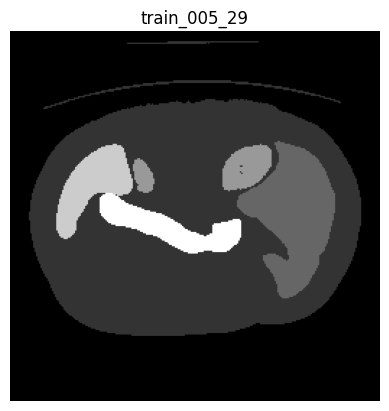

In [6]:
import matplotlib.pyplot as plt

plt.imshow(mask_file, cmap='gray')
plt.title(f'{name}')
plt.axis('off')
plt.show()

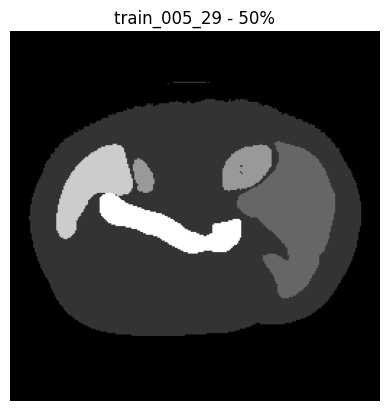

In [7]:
m_percentage = 50

for i in range(int(np.floor(mask_file.shape[0]*m_percentage/100)), 0-1, -1):
    column_sums = np.sum(mask_file[:i,:] == 1, axis=0)
    columns_to_replace = np.where((column_sums <= 3) & (column_sums > 0))[0]
    for col in columns_to_replace:
        mask_file[:i, col] = np.where(mask_file[:i, col] == 1, 0, mask_file[:i, col])

plt.imshow(mask_file, cmap='gray')
plt.title(f'{name} - {m_percentage}%')
plt.axis('off')
plt.show()

In [8]:
def setup_folders(output_path, select_folder):
    """
    Set up folders for storing processed images and masks.

    Parameters:
    - output_path (Path): The base path where the folders will be created.
    - select_folder (int): Indicator to select between training (1) or testing (other) data.

    This function creates specific subdirectories within the given output path
    based on the selection of training or testing data. It ensures the existence
    of 'train' or 'test' folders along with their 'ims' and 'masks' subfolders.
    """
    folder_type = 'train' if select_folder == 1 else 'test'
    output_path.joinpath(folder_type).mkdir(exist_ok=True)
    output_path.joinpath(folder_type, 'ims').mkdir(exist_ok=True)
    output_path.joinpath(folder_type, 'masks').mkdir(exist_ok=True)

In [9]:
def get_paths(output_path, select_folder):
    """
    Generate paths for storing images and masks.

    Parameters:
    - output_path (Path): The base path for output.
    - select_folder (int): Indicator to select between training (1) or testing (other) data.

    Returns:
    - Tuple[Path, Path]: A tuple containing the paths for storing images and masks, respectively.

    This function determines the folder type ('train' or 'test') based on the
    selection and returns the corresponding paths for images and masks.
    """
    folder_type = 'train' if select_folder == 1 else 'test'
    return output_path.joinpath(folder_type, 'ims'), output_path.joinpath(folder_type, 'masks')

In [10]:

def clean_noise_from_mask(mask_data, m_percentage):
    """
    Clean noise from the mask data.

    Parameters:
    - mask_data (ndarray): The mask data as a NumPy array.
    - m_percentage (float): Percentage of the mask to be processed for noise removal.

    This function iteratively processes rows in the mask data to remove noise,
    considering the specified percentage of the mask for processing.
    """
    for i in range(int(np.floor(mask_data.shape[0]*m_percentage/100)), 0-1, -1):
        process_columns(mask_data, i)

def verify_noise_removal(mask_data, m_percentage):
    for i in range(int(np.floor(mask_data.shape[0]*m_percentage/100)), 0-1, -1):
        process_columns(mask_data, i)

def process_columns(mask_data, row_limit):
    column_sums = np.sum(mask_data[:row_limit,:] == 1, axis=0)
    columns_to_replace = np.where((column_sums <= 3) & (column_sums > 0))[0]
    for col in columns_to_replace:
        mask_data[:row_limit, col] = np.where(mask_data[:row_limit, col] == 1, 0, mask_data[:row_limit, col])


In [11]:
def apply_mask_to_image(image_data, mask_data, value_image, value_mask):
    """
    Apply mask to an image to adjust specific pixels.

    Parameters:
    - image_data (ndarray): The image data as a NumPy array.
    - mask_data (ndarray): The mask data as a NumPy array.
    - value_image (int/float): Value to be applied to the image where the mask indicates.
    - value_mask (int/float): Value in the mask used for identifying areas to apply value_image.

    This function applies the mask to the image, changing pixel values in the
    image where the mask has the specified value_mask to the value_image.
    """
    
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            if mask_data[i,j] == value_mask:
                image_data[i,j] = value_image

In [12]:

def process_image_and_mask(image, mask, image_path, mask_path, m_percentage, value_image, value_mask):
    """
    Process a single image and its mask to remove noise.

    Parameters:
    - image (Path): Path to the image file.
    - mask (Path): Path to the corresponding mask file.
    - image_path (Path): Path to store the processed image.
    - mask_path (Path): Path to store the processed mask.
    - m_percentage (float): The percentage of the mask to be considered for noise removal.
    - value_image (int/float): Value to be applied to the image where the mask indicates.
    - value_mask (int/float): Value in the mask used for identifying areas to apply value_image.

    This function applies noise removal on both the image and its mask based on
    the specified parameters. The processed image and mask are then saved to the
    given paths.
    """
    name = mask.stem
    image_data = np.load(image)
    mask_data = np.load(mask)

    clean_noise_from_mask(mask_data, m_percentage)
    verify_noise_removal(mask_data, m_percentage)
    np.save(mask_path.joinpath(name), mask_data)

    apply_mask_to_image(image_data, mask_data, value_image, value_mask)
    np.save(image_path.joinpath(name), image_data)

In [13]:
def remove_noise(m_percentage, files_images, files_masks, value_image, value_mask, select_folder, output_path):
    """
    Remove noise from a set of images based on corresponding masks.

    Parameters:
    - m_percentage (float): The percentage of the mask to be considered for noise removal.
    - files_images (list): List of paths to the image files.
    - files_masks (list): List of paths to the corresponding mask files.
    - value_image (int/float): Value to be applied to the image where the mask indicates.
    - value_mask (int/float): Value in the mask to be used for identifying areas to apply value_image.
    - select_folder (int): Indicator to select between training (1) or testing (other) data.
    - output_path (Path): Base path for outputting the processed images and masks.

    This function processes each image and its corresponding mask to remove noise.
    It saves the processed images and masks in the specified output directory.
    """
    setup_folders(output_path, select_folder)
    image_path, mask_path = get_paths(output_path, select_folder)

    for image, mask in tqdm(zip(files_images, files_masks), desc='Removing noise'):
        process_image_and_mask(image, mask, image_path, mask_path, m_percentage, value_image, value_mask)

# Train Folder

In [14]:
remove_noise(50, images_list,mask_list,-1024,0,1,output_path) # Train with ims and masks

Removing noise: 2725it [05:13,  8.70it/s]


In [15]:
remove_noise(50, images_list,mask_list,-1024,0,2,output_path) # Test with ims and masks

Removing noise: 2725it [04:06, 11.06it/s]


# Validate the images

In [16]:
images_path = output_path.joinpath('train' if select_folder == 1 else 'test').joinpath('ims')
mask_path   = output_path.joinpath('train' if select_folder == 1 else 'test').joinpath('masks')
images_list = list(images_path.glob('*.npy'))
mask_list   = list(mask_path.glob('*.npy'))
images_list.sort(key=sorting_key)
mask_list.sort(key=sorting_key)

number=200
generar_imagenes_png(images_list[:number], mask_list[:number], cmap='gray', output_path=output_path)
print(images_list)
print('Done!')

Displaying images and masks: 200it [00:24,  8.27it/s]

[WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_0.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_1.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_2.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_3.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_4.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_5.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_6.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_7.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_8.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/0